In [1]:
import requests
import pandas as pd
import time
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns

import woo_hoo

from pathlib import Path
from rapidfuzz import fuzz
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle,
    ListFlowable, ListItem, PageBreak
)
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import A4


from woo_hoo.services.document_extractor import extract_text_from_bytes
from woo_hoo.services.metadata_generator import MetadataGenerator
from woo_hoo.models.requests import MetadataGenerationRequest, DocumentContent


## Data exploration

In [2]:
url = "https://open.overheid.nl/overheid/openbaarmakingen/api/v0/zoek"
params = {
    "zoektekst": "klimaat",
    "start": 0,
    "aantalResultaten": 20
}

response = requests.get(url, params=params)
data = response.json()


In [3]:
print(data.keys())

dict_keys(['totaal', 'resultaten', 'filters'])


In [4]:
# voorbeeld metadata van document
data["resultaten"][0]

{'document': {'id': 'oep-3497afb8171f944f3fd579e07104cd6613e46312_1',
  'pid': 'https://open.overheid.nl/documenten/oep-3497afb8171f944f3fd579e07104cd6613e46312',
  'titel': 'Wet van 28 januari 2026, houdende wijziging van de begrotingsstaten van het Ministerie van Klimaat en Groene Groei (XXIII) voor het jaar 2025 (wijziging samenhangende met de Najaarsnota)',
  'openbaarmakingsdatum': '2026-02-24',
  'weblocatie': 'https://zoek.officielebekendmakingen.nl/stb-2026-35-n1.html',
  'publisher': 'ministerie van Justitie en Veiligheid',
  'aanbieder': 'officielebekendmakingen.nl',
  'mutatiedatumtijd': '2026-02-24T08:33:28.865Z'},
 'bestandsgrootte': '0.03 MB',
 'bestandsType': 'application/pdf',
 'highlightedText': 'Staatsblad van het Koninkrijk der Nederlanden Wet van 28\xa0januari 2026 houdende wijziging van de begrotingsstaten van het Ministerie van <b>Klimaat</b> en Groene Groei XXIII voor het jaar 2025 wijziging samenhangende met de Najaarsnota'}

## Testset maken

In [5]:
def fetch_official_metadata(doc_id: str) -> dict:
    url = f"https://open.overheid.nl/overheid/openbaarmakingen/api/v0/zoek/{doc_id}"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

In [6]:
def fetch_doc_ids_with_pdf(n=20):
    base_url = "https://open.overheid.nl/overheid/openbaarmakingen/api/v0/zoek"
    
    doc_ids = []
    start = 0
    
    while len(doc_ids) < n:
        
        params = {
            "zoektekst": "",
            "start": start,
            "aantalResultaten": 20
        }

        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        results = data.get("resultaten", [])
        if not results:
            break

        for r in results:
            doc_id = r["document"]["id"]
            
            detail = fetch_official_metadata(doc_id)
            time.sleep(0.2)

            if not detail:
                continue

            pdf_url = None
            versies = detail.get("versies") or []

            if len(versies) > 0:
                bestanden = versies[0].get("bestanden") or []
                if len(bestanden) > 0:
                    pdf_url = bestanden[0].get("id")

            if pdf_url:
                doc_ids.append(doc_id)

            if len(doc_ids) >= n:
                break

        start += 20

    return doc_ids

### Daadwerkelijke documenten van testset selecteren

In [7]:
doc_ids = fetch_doc_ids_with_pdf(20)
doc_ids


['oep-3497afb8171f944f3fd579e07104cd6613e46312_1',
 'oep-608dd57a78d5bedea2004a96c57c36029f7f9e24_1',
 'oep-8bfd7eab4bc6c07fbde2692b2c867e81c7a1f331_1',
 'oep-b9e1c17ea71b4210a1debeb874269b0aa8bfc9d7_1',
 'oep-e1cf95192620b833edf9034f823fdca891921427_1',
 'oep-e6edf96dc002c95050ef793a546840b2e3e97435_1',
 'oep-ob-0639ebb1de7e171a7c5da140df82739f0bcd7976_1',
 'oep-ob-65296c1310a969285e1006c578b608cec86a7da3_1',
 'oep-ob-6c7acc2776d96737309d02f6d49fa96443ef22b2_1',
 'oep-ob-82103d41cb34a9cd1493d661fe0401fb8ea45248_1',
 'oep-ob-93dd11296bb6b51c787347c913d3c3baab64b42e_1',
 'oep-ob-f60c5d3673640c1dc0e1089ac561d1b13dd48749_1',
 'oep-06ddc6dc8da82d080eb633beba7c2b8901c93345_2',
 'oep-0712d528d06af036da2d4744f7d9819451db26a8_1',
 'oep-10230a9d1f38f89c3121bcabd8dcda0dae73e86a_1',
 'oep-19be1aec4b6ab7985c75d2ad9640fe17b55ef1d3_1',
 'oep-19fbd3a77c97d88fbfe938d2854b60d4eb1cf85c_1',
 'oep-1d2df47d3d87d143044e3cdc3c9b08d1c851e727_1',
 'oep-3eaa81ea91079dfb3d2bf3d3fb36cd83395b249e_1',
 'oep-4144dbb

## Meta-data genereren a.d.h.v. bestaande back-end

In [8]:
# PDF url om te testen
pdf_url = "https://open.overheid.nl/documenten/oep-ob-35b90fb89d64b1009ae2a22c8afde5733aab839a/pdf"

In [9]:
generator = MetadataGenerator()

async def generate_metadata_from_pdf_url(pdf_url: str):
    # 1. Download PDF
    response = requests.get(pdf_url)
    response.raise_for_status()
    pdf_bytes = response.content

    # 2. Extract text
    try:
        text = extract_text_from_bytes(pdf_bytes, filename="document.pdf")
    except Exception:
        return None

    # 3. Build request
    request = MetadataGenerationRequest(
        document=DocumentContent(
            text=text,
            filename="document.pdf",
            source_url=pdf_url
        ),
        include_confidence=True
    )

    # 4. Generate metadata
    result = await generator.generate(request)

    return result


In [10]:
FIELDS_TO_COMPARE = {
    "direct_fields": [
        "titel",
        "omschrijving",
        "identifiers",
        # "creatiedatum",
        "informatiecategorieen",
        "documentsoorten",
        "trefwoorden",
        "naam_opsteller"
    ],
    "organisation_fields": [
        "publisher",
        "verantwoordelijke",
        "opsteller"
    ]
}

STRATEGIES = [
    "semantic_similarity",   # fuzzy string
    "semantic_overlap",      # lijst fuzzy
    "set_overlap",           # identifiers
    "exact_match",           # datum
    "fuzzy_string"           # organisaties / naam
]

COMPARISON_STRATEGY = {
    "titel": "semantic_similarity",
    "omschrijving": "semantic_similarity",
    "identifiers": "set_overlap",
    # "creatiedatum": "exact_match",
    "informatiecategorieen": "semantic_overlap",
    "documentsoorten": "semantic_overlap",
    "trefwoorden": "semantic_overlap",
    "naam_opsteller": "fuzzy_string",
    "publisher": "fuzzy_string",
    "verantwoordelijke": "fuzzy_string",
    "opsteller": "fuzzy_string",
}


### Normalisatie en vergelijkingsfuncties

In [11]:
# helper functie voor normalisatie
def normalize_text(text: str | None) -> str:
    if not text:
        return ""
    
    text = text.lower()
    text = re.sub(r"[_\-]", " ", text)
    text = re.sub(r"\s+", " ", text)

    return text.strip()


In [12]:
def compare_semantic_similarity(a: str | None, b: str | None) -> float:
    a_norm = normalize_text(a)
    b_norm = normalize_text(b)
    
    if not a_norm or not b_norm:
        return 0.0
    
    return fuzz.token_set_ratio(a_norm, b_norm) / 100

In [13]:
def compare_semantic_overlap(list_a, list_b) -> float:
    if not list_a or not list_b:
        return 0.0

    scores = []

    for item_a in list_a:
        a_norm = normalize_text(item_a)
        best_score = 0

        for item_b in list_b:
            b_norm = normalize_text(item_b)
            score = fuzz.token_set_ratio(a_norm, b_norm)
            best_score = max(best_score, score)

        scores.append(best_score / 100)

    return sum(scores) / len(scores)

In [14]:
def compare_set_overlap(list_a, list_b) -> float:
    if not list_a or not list_b:
        return 0.0

    set_a = set(normalize_text(x) for x in list_a)
    set_b = set(normalize_text(x) for x in list_b)

    intersection = set_a.intersection(set_b)
    union = set_a.union(set_b)

    if not union:
        return 0.0

    return len(intersection) / len(union)

In [15]:
def compare_exact_match(a, b) -> float:
    return 1.0 if a == b else 0.0

In [16]:
def compare_fuzzy_string(a: str | None, b: str | None) -> float:
    return compare_semantic_similarity(a, b)

In [17]:
def compare_field(field_name, official_value, llm_value):
    strategy_map = {
        "titel": compare_semantic_similarity,
        "omschrijving": compare_semantic_similarity,
        "informatiecategorieen": compare_semantic_overlap,
        "documentsoorten": compare_semantic_overlap,
        "trefwoorden": compare_semantic_overlap,
        "identifiers": compare_set_overlap,
        # "creatiedatum": compare_exact_match,
        "naam_opsteller": compare_fuzzy_string,
        "publisher": compare_fuzzy_string,
        "verantwoordelijke": compare_fuzzy_string,
        "opsteller": compare_fuzzy_string,
    }

    func = strategy_map[field_name]
    return func(official_value, llm_value)


### Extractiefuncties

In [18]:
def extract_official_fields(official_json: dict) -> dict:
    doc = official_json.get("document", official_json)

    # --- Omschrijving robuust ophalen ---
    omschrijving = (
        doc.get("omschrijving")
        or (
            doc.get("omschrijvingen")[0]
            if doc.get("omschrijvingen")
            else None
        )
    )

    return {
        "titel": doc.get("titel") 
                 or doc.get("titelcollectie", {}).get("officieleTitel"),

        "omschrijving": omschrijving,

        "identifiers": doc.get("identifiers"),

        "informatiecategorieen": [
            cat.get("label")
            for cat in doc.get("classificatiecollectie", {})
                          .get("informatiecategorieen", [])
        ],

        "documentsoorten": [
            soort.get("label")
            for soort in doc.get("classificatiecollectie", {})
                            .get("documentsoorten", [])
        ],

        "trefwoorden": (
            doc.get("classificatiecollectie", {})
               .get("trefwoorden")
            or []
        ),

        "naam_opsteller": doc.get("naamOpsteller"),

        "publisher": (
            doc.get("publisher", {}).get("label")
            if isinstance(doc.get("publisher"), dict)
            else doc.get("publisher")
        ),

        "verantwoordelijke": (
            doc.get("verantwoordelijke", {}).get("label")
            if isinstance(doc.get("verantwoordelijke"), dict)
            else None
        ),

        "opsteller": (
            doc.get("opsteller", {}).get("label")
            if isinstance(doc.get("opsteller"), dict)
            else None
        ),
    }


In [19]:
def extract_llm_fields(diwoo_metadata) -> dict:
    """Functie voor het structureren van gegenereerde metadata"""
    
    
    return {
        "titel": diwoo_metadata.titelcollectie.officiele_titel,

        "omschrijving": (
            diwoo_metadata.omschrijvingen[0]
            if diwoo_metadata.omschrijvingen
            else None
        ),

        "identifiers": diwoo_metadata.identifiers,

        "informatiecategorieen": [
            cat.categorie.name
            for cat in diwoo_metadata.classificatiecollectie.informatiecategorieen
        ],

        "documentsoorten": [
            soort.soort.name
            for soort in diwoo_metadata.classificatiecollectie.documentsoorten or []
        ],

        "trefwoorden": diwoo_metadata.classificatiecollectie.trefwoorden,

        "naam_opsteller": diwoo_metadata.naam_opsteller,

        "publisher": diwoo_metadata.publisher.label if diwoo_metadata.publisher else None,

        "verantwoordelijke": (
            diwoo_metadata.verantwoordelijke.label
            if diwoo_metadata.verantwoordelijke else None
        ),

        "opsteller": (
            diwoo_metadata.opsteller.label
            if diwoo_metadata.opsteller else None
        ),
    }


### Benchmark & kosten voor documenten berekenen

In [20]:
# haal PDF url op
def get_pdf_url_from_official_metadata(official_metadata_json):
    return official_metadata_json.get("versies", [{}])[0] \
                                .get("bestanden", [{}])[0] \
                                .get("id")

In [21]:
# haal officiële metadata op
def prepare_document(doc_id: str):
    official_metadata_json = fetch_official_metadata(doc_id)
    pdf_url = get_pdf_url_from_official_metadata(official_metadata_json)

    if not pdf_url:
        return None, None

    return official_metadata_json, pdf_url

In [22]:
# benchmark scores voor 1 document berekenen
async def benchmark_from_result(doc_id: str, official_metadata_json: dict, result):
    # 1. Officiële metadata
    official_fields = extract_official_fields(official_metadata_json)

    if result is None or (hasattr(result, "success") and not result.success):
        return None

    # 2. LLM velden
    llm_fields = extract_llm_fields(result.suggestion.metadata)

    # 3. Scores berekenen
    rows = []

    for field, official_value in official_fields.items():
        if field == "creatiedatum":
            continue

        if official_value is None:
            continue

        if isinstance(official_value, list) and len(official_value) == 0:
            continue

        llm_value = llm_fields.get(field)
        score = compare_field(field, official_value, llm_value)

        if score is None:
            continue

        rows.append({
            "doc_id": doc_id,
            "field": field,
            "official_value": official_value,
            "llm_value": llm_value,
            "score": score
        })

    return pd.DataFrame(rows)

In [23]:
# kosten voor 1 document berekenen
async def costs_from_result(doc_id: str, result):
    if result is None or (hasattr(result, "success") and not result.success):
        return None

    s = result.suggestion

    return pd.DataFrame([{
        "doc_id": doc_id,
        "prompt_tokens": s.prompt_tokens,
        "completion_tokens": s.completion_tokens,
        "total_tokens": s.total_tokens,
    }])

In [24]:
# gecombineerde loop
dfs1 = []
dfs2 = []

for doc_id in doc_ids:
    try:
        official_metadata_json, pdf_url = prepare_document(doc_id)
        if not pdf_url:
            continue

        # ✅ 1x LLM call per document
        result = await generate_metadata_from_pdf_url(pdf_url)
        if result is None or not result.success:
            continue

        df_doc1 = await benchmark_from_result(doc_id, official_metadata_json, result)
        df_doc2 = await costs_from_result(doc_id, result)

        if df_doc1 is not None:
            dfs1.append(df_doc1)

        if df_doc2 is not None:
            dfs2.append(df_doc2)

    except Exception as e:
        print("Skip door fout:", doc_id, e)
        continue

benchmark_df = pd.concat(dfs1, ignore_index=True)
costs_df = pd.concat(dfs2, ignore_index=True)

2026-02-24 09:34:39 [info     ] Starting metadata generation   has_publisher_hint=False output_mode=xml request_id=3f16888c-0da2-4e55-b0b6-af7814b418d4 text_length=491
2026-02-24 09:34:39 [debug    ] Loaded TOML config             keys=['metadata', 'output', 'rules', 'extraction', 'categories', 'documentsoorten', 'handelingen', 'relaties', 'template'] name=diwoo_schema
2026-02-24 09:34:57 [info     ] OpenRouter request completed   elapsed_ms=17808 model=mistralai/mistral-large-2512
2026-02-24 09:34:57 [info     ] Metadata generation completed  completion_tokens=1402 elapsed_ms=17814 output_mode=xml overall_confidence=0.8 prompt_tokens=3613 request_id=3f16888c-0da2-4e55-b0b6-af7814b418d4 total_tokens=5015
2026-02-24 09:34:57 [info     ] Starting metadata generation   has_publisher_hint=False output_mode=xml request_id=1ca719c8-7120-4a3f-8a4a-0b179e74f549 text_length=392
2026-02-24 09:35:14 [info     ] OpenRouter request completed   elapsed_ms=16400 model=mistralai/mistral-large-2512
202

In [25]:
benchmark_df

,doc_id,field,official_value,llm_value,score
0,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,titel,"Wet van 28 januari 2026, houdende wijziging va...","Wet van 28 januari 2026, houdende wijziging va...",1.000000
1,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,identifiers,[stb-2026-35-n1],"[stb-2026-35-n1, Staatsblad 2026, 35-n1]",0.500000
2,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,informatiecategorieen,[wetten en algemeen verbindende voorschriften],[WETTEN_AVV],0.750000
3,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,documentsoorten,[Staatsblad],[BESLUIT],0.235294
4,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,publisher,ministerie van Justitie en Veiligheid,Ministerie van Justitie en Veiligheid,1.000000
...,...,...,...,...,...
128,oep-4144dbbf22e38cfb36f3a6f64a10ff7a7d2c6e49_1,informatiecategorieen,[wetten en algemeen verbindende voorschriften],[WETTEN_AVV],0.750000
129,oep-4144dbbf22e38cfb36f3a6f64a10ff7a7d2c6e49_1,documentsoorten,[Staatsblad],[BESLUIT],0.235294
130,oep-4144dbbf22e38cfb36f3a6f64a10ff7a7d2c6e49_1,publisher,ministerie van Justitie en Veiligheid,"Ministerie van Landbouw, Visserij, Voedselzeke...",0.629630
131,oep-4144dbbf22e38cfb36f3a6f64a10ff7a7d2c6e49_1,verantwoordelijke,"ministerie van Landbouw, Visserij, Voedselzeke...",Koninkrijk der Nederlanden,0.344828


In [26]:
costs_df

,doc_id,prompt_tokens,completion_tokens,total_tokens
0,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,3613,1402,5015
1,oep-608dd57a78d5bedea2004a96c57c36029f7f9e24_1,3574,1305,4879
2,oep-8bfd7eab4bc6c07fbde2692b2c867e81c7a1f331_1,3608,1496,5104
3,oep-b9e1c17ea71b4210a1debeb874269b0aa8bfc9d7_1,4507,1426,5933
4,oep-e1cf95192620b833edf9034f823fdca891921427_1,4449,1481,5930
5,oep-e6edf96dc002c95050ef793a546840b2e3e97435_1,3615,1262,4877
6,oep-ob-0639ebb1de7e171a7c5da140df82739f0bcd7976_1,4449,1484,5933
7,oep-ob-65296c1310a969285e1006c578b608cec86a7da3_1,3615,1244,4859
8,oep-ob-6c7acc2776d96737309d02f6d49fa96443ef22b2_1,3608,1409,5017
9,oep-ob-82103d41cb34a9cd1493d661fe0401fb8ea45248_1,3613,1389,5002


### Gemiddeldes / totalen berekenen

Voor kosten:

In [27]:
costs_df[["prompt_tokens","completion_tokens","total_tokens"]].mean()

prompt_tokens        4369.368421
completion_tokens    1462.684211
total_tokens         5832.052632
dtype: float64

In [28]:
# huidige kosten voor Mistral Large 2411
INPUT_PRICE = 2 / 1_000_000
OUTPUT_PRICE = 6 / 1_000_000

In [29]:
# kosten toevoegen aan costs_df
costs_df["cost_usd"] = (
    costs_df["prompt_tokens"] * INPUT_PRICE +
    costs_df["completion_tokens"] * OUTPUT_PRICE
)

costs_df["doc_number"] = costs_df.index + 1

In [30]:
costs_df

,doc_id,prompt_tokens,completion_tokens,total_tokens,cost_usd,doc_number
0,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,3613,1402,5015,0.015638,1
1,oep-608dd57a78d5bedea2004a96c57c36029f7f9e24_1,3574,1305,4879,0.014978,2
2,oep-8bfd7eab4bc6c07fbde2692b2c867e81c7a1f331_1,3608,1496,5104,0.016192,3
3,oep-b9e1c17ea71b4210a1debeb874269b0aa8bfc9d7_1,4507,1426,5933,0.017570,4
4,oep-e1cf95192620b833edf9034f823fdca891921427_1,4449,1481,5930,0.017784,5
5,oep-e6edf96dc002c95050ef793a546840b2e3e97435_1,3615,1262,4877,0.014802,6
6,oep-ob-0639ebb1de7e171a7c5da140df82739f0bcd7976_1,4449,1484,5933,0.017802,7
7,oep-ob-65296c1310a969285e1006c578b608cec86a7da3_1,3615,1244,4859,0.014694,8
8,oep-ob-6c7acc2776d96737309d02f6d49fa96443ef22b2_1,3608,1409,5017,0.015670,9
9,oep-ob-82103d41cb34a9cd1493d661fe0401fb8ea45248_1,3613,1389,5002,0.015560,10


In [53]:
avg_total_tokens = costs_df["total_tokens"].mean()
avg_cost = costs_df["cost_usd"].mean()

print("Gemiddeld totaal aantal tokens per document:",
      round(avg_total_tokens))

print("Gemiddelde kosten per document voor Mistral Large 2411 ($):",
      round(avg_cost, 4))

Gemiddeld totaal aantal tokens per document: 5832
Gemiddelde kosten per document voor Mistral Large 2411 ($): 0.0175


In [57]:
# vergelijking tussen meerdere modellen
MODEL_PRICING = {
    "mistral-large-2411": {
        "input": 2 / 1_000_000,
        "output": 6 / 1_000_000,
    },
    "mistral-medium-3": {
        "input": 0.4 / 1_000_000,
        "output": 2 / 1_000_000,
    },
    "gemini-3-pro-preview": {
        "input": 2 / 1_000_000,
        "output": 12 / 1_000_000,
    },
    "gemini-3-flash-preview": {
        "input": 0.5 / 1_000_000,
        "output": 3 / 1_000_000,
    },
    "gpt-5.2-pro": {
        "input": 21 / 1_000_000,
        "output": 168 / 1_000_000,
    },
    "gpt-4o": {
        "input": 2.5 / 1_000_000,
        "output": 10 / 1_000_000,
    },
    "claude-sonnet-4": {
        "input": 3 / 1_000_000,
        "output": 15 / 1_000_000,
    },
    "deepseek-v3.2": {
        "input": 0.26 / 1_000_000,
        "output": 0.38 / 1_000_000,
    },
    "llama-3.3-70b-instruct": {
        "input": 0.1 / 1_000_000,
        "output": 0.32 / 1_000_000,
    },
     "mixtral-8x22b-instruct": {
        "input": 0.1 / 1_000_000,
        "output": 0.32 / 1_000_000,
    }
}

In [58]:
avg_prompt = costs_df["prompt_tokens"].mean()
avg_completion = costs_df["completion_tokens"].mean()

In [60]:
model_cost_rows = []

for model_name, pricing in MODEL_PRICING.items():
    avg_cost = (
        avg_prompt * pricing["input"] +
        avg_completion * pricing["output"]
    )
    
    model_cost_rows.append({
        "model": model_name,
        "avg_cost_usd": round(avg_cost, 3)
    })

model_cost_df = pd.DataFrame(model_cost_rows)
model_cost_df

,model,avg_cost_usd
0,mistral-large-2411,0.018
1,mistral-medium-3,0.005
2,gemini-3-pro-preview,0.026
3,gemini-3-flash-preview,0.007
4,gpt-5.2-pro,0.337
5,gpt-4o,0.026
6,claude-sonnet-4,0.035
7,deepseek-v3.2,0.002
8,llama-3.3-70b-instruct,0.001
9,mixtral-8x22b-instruct,0.001


Voor benchmark scores:

In [32]:
# per document een overall score 
doc_overall_scores = (
    benchmark_df
    .groupby("doc_id")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "document_overall_score"})
)

doc_overall_scores = doc_overall_scores.reset_index(drop=True)
doc_overall_scores["doc_number"] = doc_overall_scores.index + 1


In [33]:
# per veld gemiddelde score (over alle documenten)

field_average_scores = (
    benchmark_df
    .groupby("field")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "field_average_score"})
    .sort_values("field_average_score", ascending=False)
)

In [34]:
# totale gemiddelde overall score (over alle documenten)
total_overall_score = doc_overall_scores["document_overall_score"].mean()

In [35]:
print("=== Per document overall score ===")
display(doc_overall_scores)

print("\n=== Per veld gemiddelde score ===")
display(field_average_scores)

print("\n=== Totale gemiddelde overall score ===")
print(round(total_overall_score, 3))


=== Per document overall score ===


,doc_id,document_overall_score,doc_number
0,oep-06ddc6dc8da82d080eb633beba7c2b8901c93345_2,0.473457,1
1,oep-0712d528d06af036da2d4744f7d9819451db26a8_1,0.342082,2
2,oep-10230a9d1f38f89c3121bcabd8dcda0dae73e86a_1,0.570867,3
3,oep-19fbd3a77c97d88fbfe938d2854b60d4eb1cf85c_1,0.565925,4
4,oep-1d2df47d3d87d143044e3cdc3c9b08d1c851e727_1,0.427649,5
5,oep-3497afb8171f944f3fd579e07104cd6613e46312_1,0.637107,6
6,oep-3eaa81ea91079dfb3d2bf3d3fb36cd83395b249e_1,0.266800,7
7,oep-4144dbbf22e38cfb36f3a6f64a10ff7a7d2c6e49_1,0.512253,8
8,oep-608dd57a78d5bedea2004a96c57c36029f7f9e24_1,0.690017,9
9,oep-8bfd7eab4bc6c07fbde2692b2c867e81c7a1f331_1,0.666208,10



=== Per veld gemiddelde score ===


,field,field_average_score
5,titel,0.939611
2,informatiecategorieen,0.719265
4,publisher,0.638890
6,verantwoordelijke,0.527930
1,identifiers,0.473684
3,opsteller,0.343804
0,documentsoorten,0.254842



=== Totale gemiddelde overall score ===
0.557


### Visualisaties

In [36]:
sns.set_theme(style="whitegrid", context="talk")


Voor kosten:

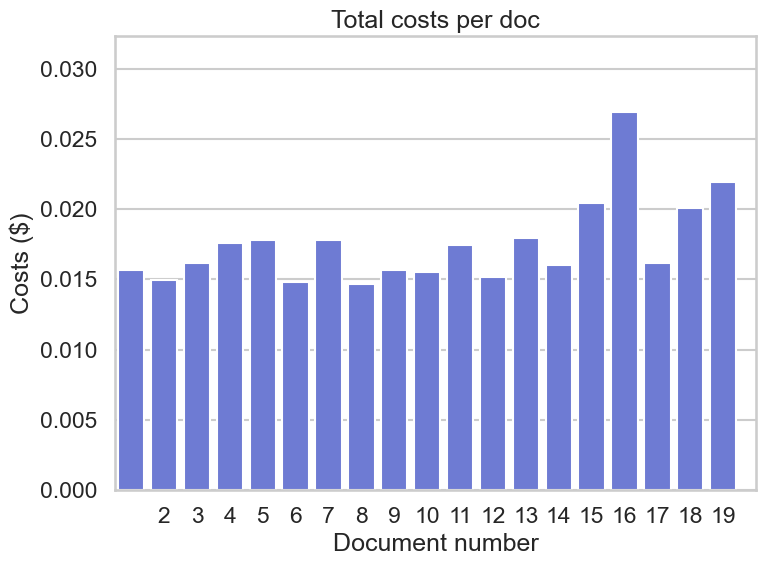

In [86]:
# overall score per document
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x="doc_number",
    y="cost_usd",
    data=costs_df,
    color="#5D6FE4"
)

plt.xticks(costs_df["doc_number"])
plt.ylim(0, costs_df["cost_usd"].max() * 1.2)
plt.xlabel("Document number")
plt.ylabel("Costs ($)")
plt.title("Total costs per doc")

# for container in ax.containers:
#     ax.bar_label(container, fmt="%.3f$", padding=4)

plt.tight_layout()
plt.savefig("costs_per_document.png")
plt.show()


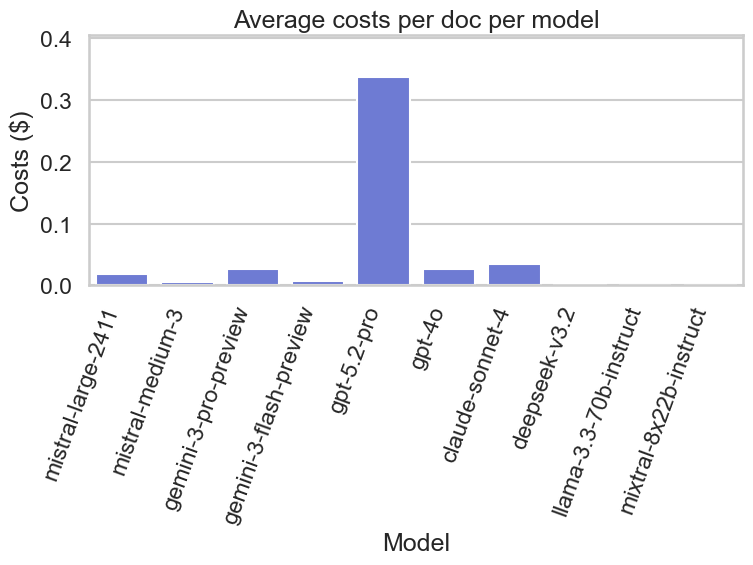

In [91]:
# gemiddelde kosten per model
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x="model",
    y="avg_cost_usd",
    data=model_cost_df,
    color="#5D6FE4"
)

plt.xticks(rotation=70, ha="right")
plt.ylim(0, model_cost_df["avg_cost_usd"].max() * 1.2)

plt.xlabel("Model")
plt.ylabel("Costs ($)")
plt.title("Average costs per doc per model")

# Optioneel: labels boven de bars (zoals je eerder deed)
# for container in ax.containers:
#     ax.bar_label(container, fmt="%.3f$", padding=4)

plt.tight_layout()
plt.savefig("costs_per_model.png")
plt.show()

Voor benchmark scores:

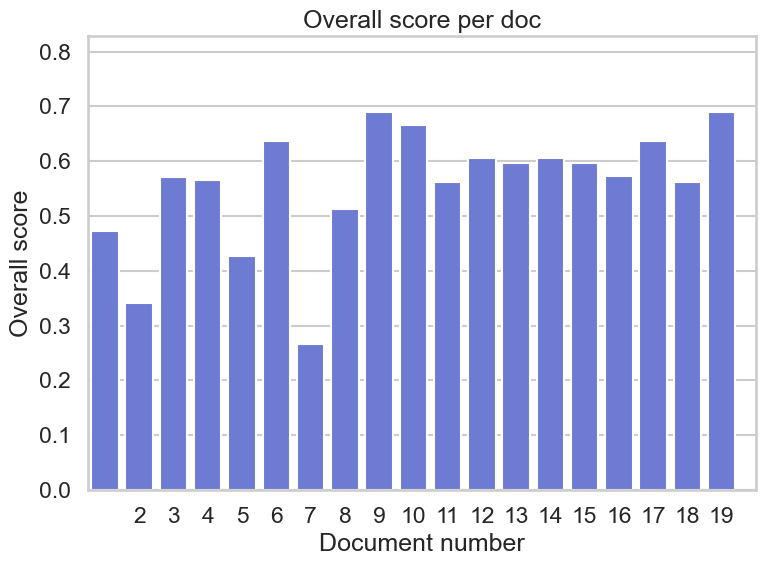

In [87]:
# overall score per document
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x="doc_number",
    y="document_overall_score",
    data=doc_overall_scores,
    color="#5D6FE4"
)

plt.xticks(doc_overall_scores["doc_number"])
plt.ylim(0, doc_overall_scores["document_overall_score"].max() * 1.2)
plt.xlabel("Document number")
plt.ylabel("Overall score")
plt.title("Overall score per doc")

# for container in ax.containers:
#     ax.bar_label(container, fmt="%.2f", padding=4, rotation=90)

plt.tight_layout()
plt.savefig("overall_per_document.png")
plt.show()


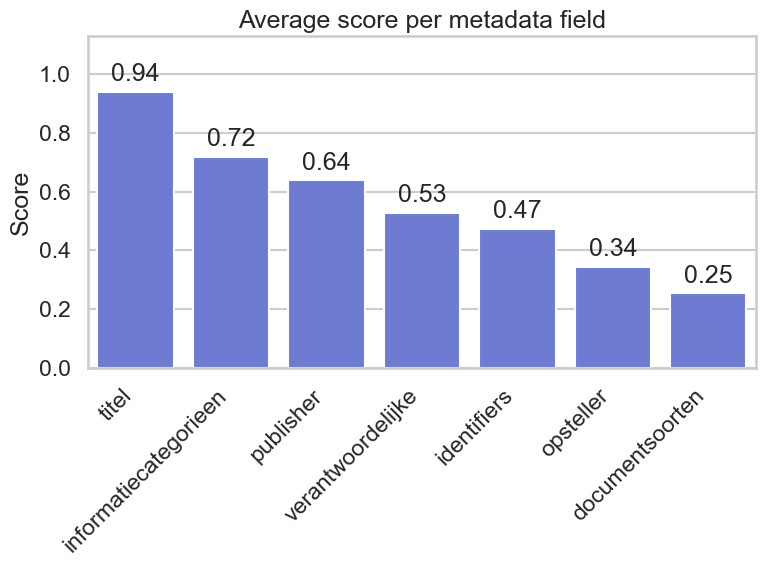

In [88]:
# gemiddelde score per veld
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x="field",
    y="field_average_score",
    data=field_average_scores,
    color="#5D6FE4"
)

plt.xticks(rotation=45, ha="right")
plt.ylim(0, field_average_scores["field_average_score"].max() * 1.2)
plt.ylabel("Score")
plt.xlabel("")
plt.title("Average score per metadata field")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=4)

plt.tight_layout()
plt.savefig("average_per_field.png")
plt.show()



### PDF rapport genereren

In [97]:
# =============================
# Aggregations
# =============================

doc_overall_scores = (
    benchmark_df
    .groupby("doc_id")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "document_overall_score"})
)

doc_overall_scores = doc_overall_scores.reset_index(drop=True)
doc_overall_scores["doc_number"] = doc_overall_scores.index + 1

field_average_scores = (
    benchmark_df
    .groupby("field")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "field_average_score"})
    .sort_values("field_average_score", ascending=False)
)

total_overall_score = doc_overall_scores["document_overall_score"].mean()

avg_total_tokens = costs_df["total_tokens"].mean()
avg_cost = costs_df["cost_usd"].mean()

# =============================
# Example Comparisons (with wrapping)
# =============================

styles = getSampleStyleSheet()

small_style = ParagraphStyle(
    name="Small",
    parent=styles["Normal"],
    fontSize=8,
    leading=10
)

sample_rows = benchmark_df.head(21)

example_table_data = [
    ["Doc", "Field", "Official", "LLM", "Score"]
]

for _, row in sample_rows.iterrows():
    example_table_data.append([
        Paragraph(row["doc_id"][:8], small_style),
        Paragraph(str(row["field"]), small_style),
        Paragraph(str(row["official_value"]), small_style),
        Paragraph(str(row["llm_value"]), small_style),
        Paragraph(str(round(row["score"], 3)), small_style),
    ])

# =============================
# Generate PDF
# =============================

pdf_path = "LLM_Metadata_Benchmark_Report_Final.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=A4)
elements = []

title_style = styles["Heading1"]
section_style = styles["Heading2"]
normal = styles["Normal"]

# Title
elements.append(Paragraph("LLM Metadata Benchmark Report", title_style))
elements.append(Spacer(1, 20))

# Introduction
elements.append(Paragraph("Introduction", section_style))
elements.append(Spacer(1, 10))

intro_text = """
To assess whether metadata generation by a Large Language Model (LLM) 
is sufficiently reliable for documents published via the GPP-WOO 
publication platform, a benchmark test was conducted.

For this benchmark, 20 documents were selected via OpenOverheid 
(<a href="https://open.overheid.nl/home" color="blue">https://open.overheid.nl/home</a>). For each document in this test set, 
the official metadata was compared with the metadata generated by the LLM. 
The model used for this report is Mistral Large 2411.

The comparison focuses exclusively on the metadata fields that are 
actually used within the publication process of the GPP-WOO platform.

The applied comparison methodology differs per field type. Depending 
on the nature of the field, fuzzy string similarity, set overlap, 
or semantic overlap is used. Based on this, a score is calculated per 
field and per document, after which aggregated results provide insight 
into the overall performance of the LLM.
"""

elements.append(Paragraph(intro_text, normal))
elements.append(Spacer(1, 20))

# Methodology
elements.append(Paragraph("Comparison Methodology", section_style))
elements.append(Spacer(1, 10))

methods = [
    "Title → Fuzzy string similarity",
    "Identifiers → Set overlap (Jaccard)",
    "Information categories → Fuzzy semantic overlap",
    "Document types → Fuzzy overlap",
    "Publisher / Responsible authority / Author → Fuzzy string similarity"
]

elements.append(ListFlowable(
    [ListItem(Paragraph(m, normal)) for m in methods],
    bulletType="bullet"
))
elements.append(Spacer(1, 20))

# Numerical Results
elements.append(Paragraph("Numerical Results", section_style))
elements.append(Spacer(1, 10))

elements.append(Paragraph(
    f"Overall average score: {round(total_overall_score, 3)}",
    normal
))
elements.append(Spacer(1, 20))

field_table_data = [["Metadata field", "Average score"]]
for _, row in field_average_scores.iterrows():
    field_table_data.append([row["field"], round(row["field_average_score"], 3)])

field_table = Table(field_table_data)
field_table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
    ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
    ("VALIGN", (0, 0), (-1, -1), "MIDDLE"),
]))

elements.append(field_table)
elements.append(PageBreak())

# Token & Cost Summary
elements.append(Paragraph(
    f"Average number of LLM tokens per document: {round(avg_total_tokens)}",
    normal
))
elements.append(Paragraph(
    f"Average cost per document for Mistral Large 2411: ${round(avg_cost, 3)}",
    normal
))
elements.append(Spacer(1, 20))

cost_table_data = [["Model", "Average cost per document (USD)"]]

for _, row in model_cost_df.iterrows():
    cost_table_data.append([
        row["model"],
        f"${row['avg_cost_usd']:.4f}"
    ])

cost_table = Table(cost_table_data)
cost_table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
    ("GRID", (0, 0), (-1, -1), 0.5, colors.grey),
    ("VALIGN", (0, 0), (-1, -1), "MIDDLE"),
]))

elements.append(cost_table)
elements.append(Spacer(1, 20))

# Visualizations
elements.append(Paragraph("Visualizations", section_style))
elements.append(Spacer(1, 20))
elements.append(Image("overall_per_document.png", width=5*inch, height=4*inch))

elements.append(Spacer(1, 20))
elements.append(Image("average_per_field.png", width=5*inch, height=4*inch))

elements.append(Spacer(1, 20))
elements.append(Image("costs_per_document.png", width=5*inch, height=4*inch))

elements.append(Spacer(1, 20))
elements.append(Image("costs_per_model.png", width=5*inch, height=4*inch))

elements.append(PageBreak())

# Example Comparisons
elements.append(Paragraph("4. Example Comparisons", section_style))
elements.append(Spacer(1, 10))

example_table = Table(
    example_table_data,
    colWidths=[0.7*inch, 1.0*inch, 2.4*inch, 2.4*inch, 0.6*inch]
)

example_table.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.lightgrey),
    ("GRID", (0, 0), (-1, -1), 0.3, colors.grey),
    ("VALIGN", (0, 0), (-1, -1), "TOP"),
    ("LEFTPADDING", (0, 0), (-1, -1), 4),
    ("RIGHTPADDING", (0, 0), (-1, -1), 4)
]))

elements.append(example_table)

doc.build(elements)

print("PDF generated:", pdf_path)

PDF generated: LLM_Metadata_Benchmark_Report_Final.pdf
